# Kaggle Project - Home Price Advanced Regression Techniques
# Part 4 - Modeling

After the data pre-processing, the data now have 104 features after adding 3rd degree polynomial terms. The proposed modeling algorithm is **Lasso** which performs auto-feature selection. The hyperparameter (i.e., alpha - regulaziation coefficient) is tuned using **Pipeline** and **GridSearchCV**. Data are scaled using **StandardScaler** before the model.


## Step-1 Import Libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

%matplotlib inline

## Step-2 Load Data

### 2.1 - Load Data

In [20]:
%store -r X_train_update
%store -r X_test_update
%store -r y

print(f'Train set has {X_train_update.isna().sum().sum()} missing value.')
print(f'Test set has {X_test_update.isna().sum().sum()} missing value.')
print(f'Train set dimension: {X_train_update.shape}.')
print(f'Test set dimension: {X_test_update.shape}.')
print(f'label dimension: {y.shape[0]}.')

Train set has 0 missing value.
Test set has 0 missing value.
Train set dimension: (1458, 104).
Test set dimension: (1459, 104).
label dimension: 1458.


### 2.2 - Transform Label

To fit_transform y with PowerTransfomer in this notebook so the predicted y can be inversely transformed.

In [21]:
pt = PowerTransformer(method='yeo-johnson', # use yeo-johnson transformation
                      standardize=True, 
                      copy=True)
y_pt = pt.fit_transform(y)

## Step-3 Linear Regression with Lasso Regularization

### 3.1 - Model

In [22]:
# Instantiate pipeline
pipe = Pipeline([
    ('sc', StandardScaler()),
    ('lasso', Lasso(random_state=42))
])

# Hyperparameters for GridSearchCV
param = {
    'lasso__alpha': np.logspace(-4, 2, 7)
}

# GridSearch
search = GridSearchCV(estimator=pipe,
                      param_grid=param,
                      cv=5,
                      n_jobs=-1,
                      return_train_score=True,
                      verbose=1)

search.fit(X_train_update, y_pt.ravel())
y_val_pt = search.predict(X_train_update)
y_pred_pt = search.predict(X_test_update)
y_val = pt.inverse_transform(y_val_pt.reshape(len(y_val_pt), 1))
y_pred = pt.inverse_transform(y_pred_pt.reshape(len(y_pred_pt), 1))


# Prepare for Submission
y_lasso = pd.DataFrame(y_pred, columns=['SalePrice'])
y_lasso['Id'] = X_test_update.index
y_lasso = y_lasso[['Id', 'SalePrice']]
y_lasso.to_csv('../submissions/lasso_no_outliers.csv', index=False)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  35 | elapsed:    4.6s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    4.6s finished
/Users/kaizhao/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/kaizhao/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/kaizhao/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/kaizhao/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversio

### 3.2 - Model Evaluation

#### Hyperparameter of Best Model

In [23]:
search.best_estimator_

Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False))])

#### Refit model to Extract Coefficient

In [24]:
# Instantiate StandardScaler
sc = StandardScaler()
lasso = Lasso(alpha=0.01)
# Scale Xs
X_train_sc = sc.fit_transform(X_train_update)
X_test_sc = sc.transform(X_test_update)
# Transform Xs to PCAs
lasso.fit(X_train_sc, y_pt.ravel())
y_val_pt = lasso.predict(X_train_sc)
y_pred_pt = lasso.predict(X_test_sc)
y_val = pt.inverse_transform(y_val_pt.reshape(len(y_val_pt), 1))
y_pred = pt.inverse_transform(y_pred_pt.reshape(len(y_pred_pt), 1))

/Users/kaizhao/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/kaizhao/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/kaizhao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


#### Error Plot

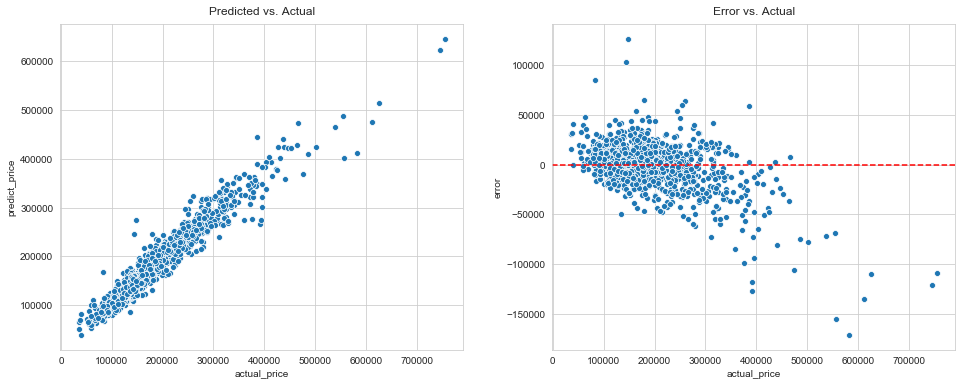

In [25]:
evaluate = pd.DataFrame()
evaluate['actual_price'] = y['SalePrice'].values
evaluate['predict_price'] = y_val.ravel()
evaluate['error'] = evaluate['predict_price'] - evaluate['actual_price']
evaluate.index=X_train_update.index

# Plots
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    # relation plot
    sns.scatterplot(data=evaluate, x='actual_price', y='predict_price', ax=ax[0])
    ax[0].set_title('Predicted vs. Actual', fontsize=12, pad=9)
    # error plot
    sns.scatterplot(data=evaluate, x='actual_price', y='error', ax=ax[1])
    ax[1].axhline(y=0, color='r', linestyle='--')
    ax[1].set_title('Error vs. Actual', fontsize=12, pad=9)
    plt.tight_layout(pad=3)
    plt.show();

In [26]:
def data_tuning(error_threshold, df=evaluate, error='error'):
    mask = (df[error] > error_threshold) | (df[error] < -error_threshold)
    return df[mask].index.to_list()

In [27]:
data_for_removal = data_tuning(error_threshold=70000)
data_for_removal

[179,
 186,
 219,
 314,
 379,
 474,
 589,
 609,
 633,
 689,
 692,
 770,
 775,
 799,
 804,
 899,
 1047,
 1170,
 1182,
 1183,
 1325]

#### Coefficient Plot

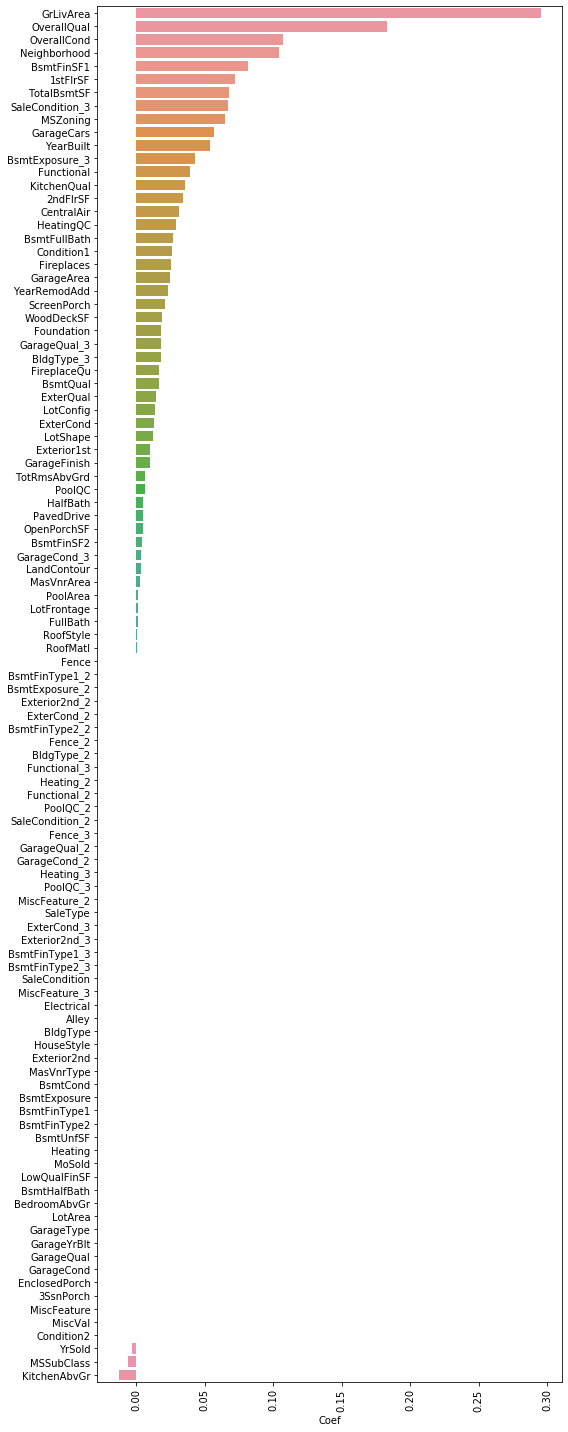

In [28]:
coef = pd.DataFrame(lasso.coef_, 
                    index=X_train_update.columns, 
                    columns=['Coef']).sort_values(by='Coef', 
                                                  ascending=False)
# Plot Coefficient
plt.figure(figsize=(8, 20))
sns.barplot(data=coef, y=coef.index, x='Coef', orient='h')
plt.xticks(rotation=90)
plt.tight_layout();

Coefficient based the LASSO's feature selection consists with the correlation presented in **Part 2-EDA**. Some of the higher order terms such as `SalesCondition_3`, `BsmtExposure_3`, and `GarageQual_3` also made contributes. Most of the higher order terms were deselected by the model. It is likely the model is overfitting. Additional tuning is recommended. 

#### R^2 Score

In [29]:
r2_score(y_pt, y_val_pt)

0.9226832582727893

## Step-4 Save Tuning Data

In [30]:
%store data_for_removal

Stored 'data_for_removal' (list)
